In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import os
from collections import Counter

from time import time

%matplotlib inline

import scipy.sparse

In [2]:
def id_counter(id_list):
    cnt = Counter()
    for el in id_list:
        cnt[el[u'element']] = el[u'count']
    return cnt

def_black_list = { 'unit', 'units', 'value', 'values', 'axis', 'axes', 'factor', 'factors', 'line', 'lines',
                 'point', 'points', 'number', 'numbers', 'variable', 'variables', 'respect', 'case', 'cases',
                 'vector', 'vectors', 'element', 'elements', 'example', 
                 'integer', 'integers', 'term', 'terms', 'parameter', 'parameters', 'coefficient', 'coefficients',
                 'formula', 'times', 'product', 'matrices', 'expression', 'complex', 'real', 'zeros', 'bits',
                 'sign',
                 'if and only if',
                 'alpha', 'beta', 'gamma', 'delta', 'epsilon', 'zeta', 'eta', 'theta', 'iota', 'kappa', 'lambda', 
                 'mu', 'nu', 'xi', 'omicron', 'pi', 'rho', 'sigma', 'tau', 'upsilon', 'phi', 'chi', 'psi', 'omega'}

def valid_def(definition):
    if len(definition) <= 3:
        return False

    return definition.lower() not in def_black_list

def rel_to_dict(rels):
    res = defaultdict(list)
    for r in rels:
        if not valid_def(r['definition']):
            continue
        res[r['identifier']].append((r['definition'], r['score']))
    return res

In [3]:
from collections import defaultdict

doc_categories = defaultdict(set)
category_docs = defaultdict(set)

for line in file('C:/tmp/mlp/category_info_refined.txt'):
    title, cat = line.strip().split('\t')
    title = title.decode('utf-8')
    cat = cat.decode('utf-8')

    # let's also remove all documents from "OTHER" category
    if cat == u'OTHER':
        continue

    doc_categories[title].add(cat) 
    category_docs[cat].add(title)

In [4]:
root = 'C:/tmp/mlp/mlp-output/'

docs = []
titles = []
ids = []
rels = []

empty = 0
small = 0
uncategorized = 0

for f in os.listdir(root): 
    for line in file(root + f):
        doc = json.loads(line)

        title = doc['title']        
        if title not in doc_categories:
            uncategorized = uncategorized + 1
            continue

        if '(disambiguation)' in title:
            continue

        id_bag = id_counter(doc['identifiers'])
        if len(id_bag) <= 1:
            if len(id_bag) == 0:
                empty = empty + 1
            else:
                small = small + 1
            continue

        docs.append(doc)
        titles.append(title)
        ids.append(id_bag)

        id_rels = rel_to_dict(doc['relations'])
        rels.append(id_rels)

print empty, small, uncategorized

N_doc = len(ids)
print N_doc

0 0 7501
22512


In [5]:
title_idx = {title: idx for (idx, title) in enumerate(titles)}

for doc, cats in doc_categories.items():
    if doc in title_idx:
        continue

    for cat in cats: 
        category_docs[cat].remove(doc)
    
    del doc_categories[doc]

print len(doc_categories)

22512


In [6]:
doc_categories_list = [doc_categories[doc] for doc in titles]

Let's keep a copy of identifiers

In [17]:
ids = [id_counter(d['identifiers']) for d in docs]

Norm - to see what effect dim reduction has

In [7]:
def norm2(cntr):
    return sum(cnt * cnt for cnt in cntr.values())

def norm(cntr):
    return np.sqrt(norm2(cntr))

In [8]:
np.mean([norm(cnt) for cnt in ids])

28.23118431717846

remove least common

In [18]:
all_ids = Counter()

for id_cnt in ids:
    all_ids.update(id_cnt)

print len(all_ids)

infrequent = set()
min_count = 15

for (el, cnt) in all_ids.items():
    if cnt <= min_count:
        infrequent.add(el)

print len(infrequent)

for id_cnt in ids:
    for id in (set(id_cnt) & infrequent):
        del id_cnt[id]

        
all_ids = Counter()

for id_cnt in ids:
    all_ids.update(id_cnt)

print len(all_ids)
        
del all_ids
del infrequent

12771
10052
2719


In [19]:
np.mean([norm(cnt) for cnt in ids])

28.11123496738713

Most common

In [20]:
df = Counter()
for cnt in ids:
    df.update(list(cnt))

top = 50
mc = [id for (id, cnt) in df.most_common(top) if cnt > 3000]
print ' '.join(mc)

mc = set(mc)

for id_cnt in ids:
    for id in list(id_cnt):
        if id in mc:
            del id_cnt[id]

del mc
del df

n t x m p d g k f R l y c r T π C P b S s N B E X F j


In [21]:
np.mean([len(doc_ids) for doc_ids in ids])

7.1480543710021323

In [22]:
np.mean([norm(cnt) for cnt in ids])

14.117618348332847

Let's incorporate found definitions

In [23]:
for idx in xrange(N_doc):
    vals = rels[idx].items()
    id_list = ids[idx]

    for id, definitions in vals:
        for definition, score in definitions:
            unigrams = definition.lower().split()
            id_list[id] = id_list[id] + 1
            id_list.update(unigrams)

In [16]:
np.mean([len(doc_ids) for doc_ids in ids])

20.676750177683015

In [17]:
np.mean([norm(cnt) for cnt in ids])

18.144577330249831

Inverted index

In [24]:
inv_idx = {}

for (idx, id_list) in enumerate(ids):
    for id in id_list: 
        if id in inv_idx:
            inv_idx[id].append(idx)
        else:
            inv_idx[id] = [idx]

In [25]:
def docs_to_compare(doc_id):
    res = set([])
    id_list = ids[doc_id]
    for id in id_list:
        res.update(inv_idx[id])
    if doc_id in res:
        res.remove(doc_id)
    return res

## Jaccard 

In [347]:
k_graph = 15
k_matrix = 50
sim_threshold = 0.5
shared_nn = []

jaccard_sim_matrix = scipy.sparse.dok_matrix(((N_doc, N_doc)))

In [14]:
ids_sets = [set(id_list) for id_list in ids]

def calc_jaccard(set1, set2):
    union = len(set1 | set2)
    if not union: 
        return 0.0

    inter = len(set1 & set2)
    return inter * 1.0 / union

In [15]:
np.mean([len(docs_to_compare(doc_id)) for doc_id in xrange(200)])

4719.165

In [350]:
t0 = time()

for i in xrange(N_doc):
    if i % 1000 == 0:
        print "iteration %d" % i

    doc_ids = np.array(list(docs_to_compare(i)))
    sim = np.zeros(len(doc_ids))

    for (idx, j) in enumerate(doc_ids):
        sim[idx] = calc_jaccard(ids_sets[i], ids_sets[j])
    
    sim_idx = sim.argsort()[-1:-k_matrix-1:-1]
    doc_ids_to_add = doc_ids[sim_idx]

    shared_nn.append(set(doc_ids_to_add[0:k_graph]))
    jaccard_sim_matrix[i, doc_ids_to_add] = sim[sim_idx]


print "done in %0.3fs." % (time() - t0)

iteration 0
iteration 1000
iteration 2000
iteration 3000
iteration 4000
iteration 5000
iteration 6000
iteration 7000
iteration 8000
iteration 9000
iteration 10000
iteration 11000
iteration 12000
iteration 13000
iteration 14000
iteration 15000
iteration 16000
iteration 17000
iteration 18000
iteration 19000
iteration 20000
iteration 21000
iteration 22000
done in 1655.482s.


In [351]:
import snn_dbscan

Let's try to look for best params

In [105]:
import cluster_evaluation

In [106]:
reload(cluster_evaluation)
evaluate = cluster_evaluation.Evaluator(doc_titles=titles, doc_ids=ids, 
                                        doc_ids_definitions=rels, doc_categories=doc_categories_list)

In [353]:
N_doc

22512

In [365]:
reload(snn_dbscan)

<module 'snn_dbscan' from 'snn_dbscan.py'>

In [367]:
eps_list = [3, 4, 5, 6, 7, 8, 9, 10]
min_pts_list = [3, 4, 5, 6, 7]

hyperparam_purity = {}
hyperparam_res = {}

for eps in eps_list:
    for min_pts in min_pts_list:
        res = np.array(snn_dbscan.dbscan(shared_nn, eps=eps, min_pts=min_pts))
        res[res == 'noise'] = 0
        res = res.astype(int)
        
        hyperparam_res[(eps, min_pts)] = res
        cluster_purity = evaluate.overall_purity(res)
        hyperparam_purity[(eps, min_pts)] = cluster_purity

        no_clusters = len(np.unique(res))
        no_pure_clusters = len(evaluate.high_purity_clusters(res, threshold=0.8))

        print 'purity for eps=%d, min_pts=%d is %0.4f, number of clusters: %d, number of >0.8 clusters: %d' % \
              (eps, min_pts, cluster_purity, no_clusters, no_pure_clusters)

evaluating eps=5, min_pts=3...
purity for eps=5, min_pts=3 is 0.2398, number of clusters: 2023, number of >0.8 clusters: 67
evaluating eps=5, min_pts=4...
purity for eps=5, min_pts=4 is 0.2281, number of clusters: 1777, number of >0.8 clusters: 72
evaluating eps=5, min_pts=5...
purity for eps=5, min_pts=5 is 0.2200, number of clusters: 1604, number of >0.8 clusters: 69
evaluating eps=5, min_pts=6...
purity for eps=5, min_pts=6 is 0.2207, number of clusters: 1485, number of >0.8 clusters: 59
evaluating eps=5, min_pts=7...
purity for eps=5, min_pts=7 is 0.2189, number of clusters: 1410, number of >0.8 clusters: 53
evaluating eps=6, min_pts=3...
purity for eps=6, min_pts=3 is 0.2506, number of clusters: 1848, number of >0.8 clusters: 80
evaluating eps=6, min_pts=4...
purity for eps=6, min_pts=4 is 0.2351, number of clusters: 1601, number of >0.8 clusters: 76
evaluating eps=6, min_pts=5...
purity for eps=6, min_pts=5 is 0.2294, number of clusters: 1485, number of >0.8 clusters: 83
evaluati

In [376]:
evaluate.report_overall(hyperparam_res[(6, 3)], purity_threshold=0.8, sort_by='size')

overall purity 0.2506
number of high purity clusters of size at least 5 is 80

- Abstract algebra (id=100) size=54, purity=0.8519
- Coding theory (id=177) size=31, purity=0.9677
- Astronomical catalogues (id=1288) size=24, purity=1.0000
- Complex analysis (id=140) size=23, purity=1.0000
- Solid mechanics (id=103) size=22, purity=0.8636
- Group theory (id=1747) size=21, purity=0.9524
- Probability theory (id=398) size=17, purity=0.8824
- Numerical analysis (id=23) size=16, purity=0.8750
- Quantum mechanics (id=173) size=16, purity=0.8125
- Cartographic projections (id=680) size=16, purity=0.8750
- Chemical elements (id=632) size=15, purity=0.9333
- Fluid dynamics (id=661) size=15, purity=0.8000
- National Basketball Association seasons (id=830) size=15, purity=0.8000
- Physical cosmology (id=21) size=14, purity=0.8571
- Mechanics (id=145) size=14, purity=0.9286
- Theoretical physics (id=251) size=13, purity=0.8462
- Stochastic processes (id=379) size=13, purity=0.8462
- Algebraic number

In [402]:
evaluate.print_cluster(hyperparam_res[(6, 3)], 177, collection_weighting=1)

size: 31

- Plotkin bound (categories: Discrete mathematics, Information theory, Coding theory, Encodings) distance C finite d field M choices s_i length minimum F_2 x y hamming n
- Johnson bound (categories: Discrete mathematics, Information theory, Coding theory, Encodings) nonzero distance C code d n q length minimum x w entries y hamming codes
- Cyclic code (categories: Discrete mathematics, Information theory, Algebraic number theory, Field theory, Coding theory, ...) code symbols range dimension v_i principal ham generator field unity α only location columns v_0 v_1 ω H coprime F_2 d positions p vector t indices x domain modulo weight burst λc_n zero frequency nonzero errors G c_n-1 β V_j V_k coefficient C linear degree error j_1 rows c V_0 V_1 g column shift length block primitive number rank c_1 c_0 b_0 ring size l_2 Σ l_1 codewords quadratic G_j λ form c_i R V distance b word places cyclic r v S_1 S_3 constant spectrum minimum numbers D binary galois s maps ideal complex role 

In [403]:
evaluate.report_overall(hyperparam_res[(6, 5)], purity_threshold=0.8, sort_by='size')

overall purity 0.2294
number of high purity clusters of size at least 5 is 83

- Abstract algebra (id=79) size=45, purity=0.8444
- Coding theory (id=135) size=31, purity=0.9677
- Astronomical catalogues (id=1023) size=24, purity=1.0000
- Group theory (id=1406) size=24, purity=0.9167
- Solid mechanics (id=82) size=21, purity=0.8571
- Category theory (id=140) size=19, purity=0.9474
- Complex analysis (id=108) size=18, purity=1.0000
- Functional analysis (id=109) size=17, purity=0.8235
- Numerical analysis (id=20) size=16, purity=0.8750
- Probability theory (id=301) size=16, purity=0.8750
- Cartographic projections (id=531) size=16, purity=0.8750
- Chemical elements (id=496) size=15, purity=0.9333
- Fluid dynamics (id=519) size=15, purity=0.8000
- National Basketball Association seasons (id=644) size=15, purity=0.8000
- Mechanics (id=363) size=14, purity=0.9286
- Physical cosmology (id=454) size=14, purity=0.8571
- Cartography (id=226) size=12, purity=0.9167
- Radio frequency propagation 

##  K-means

In [26]:
import kmeans

In [27]:
ids = [id_counter(d['identifiers']) for d in docs]

all_ids = Counter()

for id_cnt in ids:
    all_ids.update(id_cnt)

infrequent = set()
min_count = 15

for (el, cnt) in all_ids.items():
    if cnt <= min_count:
        infrequent.add(el)

for id_cnt in ids:
    for id in (set(id_cnt) & infrequent):
        del id_cnt[id]

del all_ids
del infrequent

for idx in xrange(N_doc):
    vals = rels[idx].items()
    id_list = ids[idx]

    for id, definitions in vals:
        for definition, score in definitions:
            unigrams = definition.lower().split()
            id_list[id] = id_list[id] + 1
            id_list.update(unigrams)

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, randomized_svd

In [29]:
def unwrap_counter(cnt):
    res = []
    for id, c in cnt.items():
        res.extend([id] * c)
    return res

vectorizer = TfidfVectorizer(analyzer=unwrap_counter, use_idf=False, sublinear_tf=True)
X = vectorizer.fit_transform(ids)

In [30]:
X

<22512x26068 sparse matrix of type '<type 'numpy.float64'>'
	with 545548 stored elements in Compressed Sparse Row format>

In [168]:
for k in [1, 2, 3, 4]:
    print 'k =', (k + 1)
    evaluate.describe(lineage[k])
    print

k = 2
0 Abstract algebra (0.0775),Physics (0.0710),Theoretical physics (0.0589),Mathematical analysis (0.0446)
1 Mathematical analysis (0.1423),Fields of mathematics (0.0846),Abstract algebra (0.0748),Functions and mappings (0.0684)

k = 3
0 Abstract algebra (0.0775),Physics (0.0710),Theoretical physics (0.0589),Mathematical analysis (0.0446)
1 Mathematical analysis (0.1057),Number theory (0.0903),Combinatorics (0.0899),Fields of mathematics (0.0817)
2 Physics (0.1334),Theoretical physics (0.0839),Mechanics (0.0731),Quantum mechanics (0.0666)

k = 4
0 Physics (0.0894),Theoretical physics (0.0634),Quantum mechanics (0.0518),Abstract algebra (0.0504)
1 Mathematical analysis (0.1057),Number theory (0.0903),Combinatorics (0.0899),Fields of mathematics (0.0817)
2 Physics (0.1334),Theoretical physics (0.0839),Mechanics (0.0731),Quantum mechanics (0.0666)
3 Mathematical analysis (0.1733),Fields of mathematics (0.0871),Theoretical physics (0.0799),Abstract algebra (0.0746)

k = 5
0 Physics (0.

In [169]:
for k in [1, 2, 3, 4]:
    print 'k =', (k + 1)
    evaluate.category_distribution(lineage[k], 'Statistics', order='purity')
    print

k = 2
  1: percentage: 62.2%, coverage: 535/9518 = 0.0562
  0: percentage: 37.8%, coverage: 325/9014 = 0.0361

k = 3
  1: percentage: 34.9%, coverage: 276/4372 = 0.0631
  2: percentage: 23.9%, coverage: 189/3980 = 0.0475
  0: percentage: 41.1%, coverage: 325/9014 = 0.0361

k = 4
  1: percentage: 30.4%, coverage: 276/4372 = 0.0631
  3: percentage: 28.6%, coverage: 259/5146 = 0.0503
  2: percentage: 20.8%, coverage: 189/3980 = 0.0475
  0: percentage: 20.2%, coverage: 183/4845 = 0.0378

k = 5
  1: percentage: 28.3%, coverage: 276/4372 = 0.0631
  3: percentage: 18.9%, coverage: 184/3449 = 0.0533
  2: percentage: 19.4%, coverage: 189/3980 = 0.0475
  0: percentage: 18.8%, coverage: 183/4845 = 0.0378
  4: percentage: 14.6%, coverage: 142/4169 = 0.0341



In [173]:
purities = []

idx = 0
for labels_i in lineage:
    if idx % 10 == 0:
        print 'calculating %d...' % idx

    purities.append(evaluate.overall_purity(labels_i))
    idx = idx + 1

calculating 0...
calculating 10...
calculating 20...
calculating 30...
calculating 40...
calculating 50...
calculating 60...
calculating 70...
calculating 80...
calculating 90...
calculating 100...
calculating 110...
calculating 120...
calculating 130...
calculating 140...
calculating 150...
calculating 160...
calculating 170...
calculating 180...
calculating 190...
calculating 200...
calculating 210...
calculating 220...
calculating 230...
calculating 240...
calculating 250...
calculating 260...
calculating 270...
calculating 280...
calculating 290...
calculating 300...
calculating 310...
calculating 320...
calculating 330...
calculating 340...
calculating 350...
calculating 360...
calculating 370...
calculating 380...
calculating 390...
calculating 400...
calculating 410...
calculating 420...
calculating 430...
calculating 440...
calculating 450...
calculating 460...
calculating 470...
calculating 480...
calculating 490...
calculating 500...
calculating 510...
calculating 520...
calc

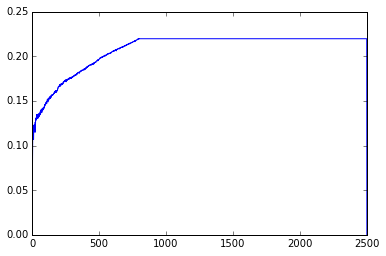

In [175]:
plt.plot(purities)
plt.show()

### LSA

In [31]:
n_components = 100
U, S, Vt = randomized_svd(X, n_components)
V = Vt.T

U.shape, S.shape, Vt.shape

((22512L, 100L), (100L,), (100L, 26068L))

In [32]:
X_red = X.dot(V)
X_red.shape

(22512L, 100L)

In [33]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer(copy=False)

In [35]:
from sklearn.cluster import KMeans, MiniBatchKMeans

Let's try different number of orthogonal vectors in LSA basis

In [39]:
n_components = [n * 100 for n in xrange(3, 8)]
ks = [k * 100 for k in xrange(25, 46)]

km_grid_hyperparam_purity = {}
km_grid_hyperparam_res = {}

for n in n_components:
    print 'doing LSA with %d components...' % n
    print

    U, S, Vt = randomized_svd(X, n_components=n)
    V = Vt.T

    X_red_grid = X.dot(V)
    X_red_grid = normalizer.fit_transform(X_red_grid)


    for k in ks:
        if k > 1000 and n > 70:
            km_grid = MiniBatchKMeans(n_clusters=k, init_size=k*3, n_init=10, init='random')
        else:
            km_grid = MiniBatchKMeans(n_clusters=k, init_size=k*3, n_init=10)
        km_grid.fit(X_red_grid)

        km_grid_hyperparam_res[(n, k)] = km_grid.labels_
        cluster_purity = evaluate.overall_purity(km_grid.labels_)
        km_grid_hyperparam_purity[(n, k)] = cluster_purity

        no_pure_clusters = len(evaluate.high_purity_clusters(km_grid.labels_, threshold=0.8))

        print 'purity for n=%d, k=%d is %0.4f, number of >0.8 clusters: %d' % (n, k, cluster_purity, no_pure_clusters)

doing LSA with 300 components...

purity for n=300, k=2500 is 0.3377, number of >0.8 clusters: 46
purity for n=300, k=2600 is 0.3339, number of >0.8 clusters: 54
purity for n=300, k=2700 is 0.3383, number of >0.8 clusters: 40
purity for n=300, k=2800 is 0.3412, number of >0.8 clusters: 48
purity for n=300, k=2900 is 0.3489, number of >0.8 clusters: 41
purity for n=300, k=3000 is 0.3489, number of >0.8 clusters: 51
purity for n=300, k=3100 is 0.3549, number of >0.8 clusters: 53
purity for n=300, k=3200 is 0.3658, number of >0.8 clusters: 64
purity for n=300, k=3300 is 0.3625, number of >0.8 clusters: 57
purity for n=300, k=3400 is 0.3815, number of >0.8 clusters: 74
purity for n=300, k=3500 is 0.3782, number of >0.8 clusters: 54
purity for n=300, k=3600 is 0.3749, number of >0.8 clusters: 64
purity for n=300, k=3700 is 0.3810, number of >0.8 clusters: 70
purity for n=300, k=3800 is 0.3955, number of >0.8 clusters: 85
purity for n=300, k=3900 is 0.3903, number of >0.8 clusters: 55
purity

In [41]:
evaluate.report_overall(km_grid_hyperparam_res[300, 4300], purity_threshold=0.8, sort_by='size')

overall purity 0.4184
number of high purity clusters of size at least 5 is 102

- Astronomical catalogues (id=1833) size=53, purity=0.9811
- Group theory (id=1309) size=18, purity=0.9444
- Thermodynamics (id=2576) size=17, purity=0.8235
- Group theory (id=1828) size=15, purity=0.8667
- Complex analysis (id=3252) size=15, purity=0.8667
- Numerical analysis (id=3364) size=15, purity=0.8667
- Electromagnetism (id=2376) size=14, purity=0.8571
- Electronic design (id=238) size=12, purity=0.9167
- Statistics (id=2410) size=12, purity=0.8333
- Quantum mechanics (id=3141) size=12, purity=0.8333
- Quantum field theory (id=1872) size=11, purity=0.8182
- Radio frequency propagation (id=222) size=10, purity=0.8000
- Automorphic forms (id=347) size=10, purity=0.9000
- Stochastic processes (id=447) size=10, purity=0.8000
- Materials science (id=724) size=10, purity=0.9000
- Signal processing (id=771) size=10, purity=0.9000
- Topology (id=1134) size=10, purity=0.9000
- Electromagnetism (id=1266) size

In [57]:
evaluate.print_cluster(km_grid_hyperparam_res[300, 4300], 1213, collection_weighting=0)

size: 6

- Lindley's paradox (categories: Statistics, Mathematical and quantitative methods (economics), Statistical theory, Econometrics, Statistical inference, ...) testing course Β H_0 p-value prior proportion same experiment θ μ boys π σ B births N P binomial words variable X account b H_2 d g H_1 k uncertainty m n hypotheses p u t time x distribution explanations
- Estimation theory (categories: Statistics, Applied mathematics, Fields of application of statistics, Signal processing, Control theory, ...) probability independent sample θ_2 θ_1 size samples θ π σ E N variance c d k m maximum n p w x
- Bayesian information criterion (categories: Statistical theory, Statistical models, Regression analysis, Statistical inference, Bayesian statistics, ...) probability x_i relative log-likelihood size information BIC criterion θ σ theory χ M L x bayesian true k transition n p magnitude schwarz error variance
- Unbiased estimation of standard deviation (categories: Statistics, Estimation t

import pickle

pickled = {'purities': km_grid_hyperparam_purity, 'clusters': km_grid_hyperparam_res}
pickle.dump(pickled, file('C:/tmp/mlp/namespaces/k-means_06.bin', 'w'))

In [48]:
evaluate.find_identifier(km_grid_hyperparam_res[300, 4300], purity_threshold=0.8, id=u'σ', collection_weighting=0)

overall purity 0.4184
number of high purity clusters of size at least 5 is 102

category "Fluid mechanics", cluster_id=71, size=8:
top categories: [(u'Fluid mechanics', 7), (u'Fluid dynamics', 5), (u'Dynamics', 5), (u'Viscosity', 3), (u'Physical quantities', 3)]
σ: (total stress tensor: 1.97), (pressure: 0.87), (material: 0.83)

category "Differential equations", cluster_id=300, size=5:
top categories: [(u'Differential equations', 4), (u'Ordinary differential equations', 4), (u'Continuous distributions', 1), (u'Conceptual systems', 1), (u'Control theory', 1)]
σ: (standard deviation: 0.83)

category "Numerical analysis", cluster_id=357, size=6:
top categories: [(u'Numerical analysis', 5), (u'Linear algebra', 5), (u'Numerical linear algebra', 5), (u'Relaxation (iterative methods)', 4), (u'Iterative methods', 4)]
σ: (boundary: 1.86), (detail: 0.87), (step: 0.81)

category "Cartography", cluster_id=503, size=5:
top categories: [(u'Cartography', 4), (u'Coordinate systems', 4), (u'Mathematic

In [122]:
reload(cluster_evaluation)
evaluate = cluster_evaluation.Evaluator(doc_titles=titles, doc_ids=ids, 
                                        doc_ids_definitions=rels, doc_categories=doc_categories_list)

In [123]:
evaluate.print_cluster(km_grid_hyperparam_res[300, 4300], 71)

size: 8

- Newtonian fluid (categories: Fluid dynamics, Dynamics, Physical quantities, Fluid mechanics, Viscosity) constant x_j x_i scalar total v_i v_j tensor system field μ fluids σ τ F component fluid y tensors stress d pressure j p vector u v coordinate velocity
- Aeroacoustics (categories: Applied and interdisciplinary physics, Fluid dynamics, Dynamics, Fluid mechanics, Aerospace engineering, ...) x_j x_i c_0 speed v_i v_j density ρ σ D fluid pressure T p_0 sound c of equation ρ_0 p mass t v
- Fluid mechanics (categories: Fluid mechanics, Continuum mechanics, Gases, Liquids, Soft matter) coefficient coordinate vortices x_j x_i second v_i v_j τ tensor symmetric state κ μ shear isotropic ρ direction D newtonian freedom viscosity fluid P drag stresses stress viscous d f h j p t components v y velocity
- Geophysical fluid dynamics (categories: Applied and interdisciplinary physics, Fluid dynamics, Dynamics, Fluid mechanics, Meteorology, ...) ρ τ f p u t v x μ d
- Viscous stress tensor

$n=700, k=4500$

In [130]:
evaluate.report_overall(km_grid_hyperparam_res[700, 4500], purity_threshold=0.8, sort_by='size')

overall purity 0.4214
number of high purity clusters of size at least 5 is 98

- Astronomical catalogues (id=1421) size=53, purity=0.9811
- Complex analysis (id=58) size=31, purity=0.8710
- Differential geometry (id=4414) size=18, purity=0.8333
- Group theory (id=1190) size=15, purity=0.8000
- Group theory (id=1104) size=14, purity=1.0000
- Set theory (id=3430) size=13, purity=0.8462
- Electromagnetism (id=670) size=12, purity=0.9167
- Field theory (id=876) size=12, purity=0.8333
- Analytic number theory (id=157) size=11, purity=0.9091
- Baseball statistics (id=460) size=11, purity=0.8182
- Probability theory (id=2039) size=11, purity=0.8182
- Statistics (id=2816) size=11, purity=0.8182
- Group theory (id=396) size=10, purity=0.8000
- Probability distributions (id=723) size=10, purity=0.8000
- Coordinate systems (id=3462) size=10, purity=0.8000
- Statistics (id=4115) size=10, purity=0.8000
- Macroeconomics and monetary economics (id=630) size=9, purity=0.8889
- Linear algebra (id=685) 

In [133]:
evaluate.print_cluster(km_grid_hyperparam_res[700, 4500], 3363)

size: 5

- Point process (categories: Statistics, Probability theory, Statistical data types, Stochastic processes, Statistical data sets, ...) random compact Ω α stochastic ρ L P half X dirac d h ϱ t x Pr kernel Φ_B radius measure event Φ state B_1 ; ξ S surely λ_p B_i B_k g cox k basis times poisson subset point x_k Λ H_t & k_1 process borel λ B_δ σ B F N R x_1 line ξ_α B_n subsets f j n k_i euclidean k_n history real almost Δ relatively - X_k lévy X_i δ T_j ball E algebra sets variable space countable time y sigma jensens
- Campbell's theorem (probability) (categories: Mathematical theorems, Probability theory, Probability theorems) set point process random measurable related intensity relation result measure Λ Σ space sum functions expectations borel theorem θ λ B E campbells sums expectation N ranges variance imaginary d g f l imaginary.a euclidean range t x quantity
- Point process notation (categories: Mathematics, Mathematical notation, Notation) set probability point process r

Old results:

In [202]:
n_components = [n * 100 for n in xrange(3, 8)]
ks = [k * 100 for k in xrange(25, 46)]

km_grid_hyperparam_purity = {}
km_grid_hyperparam_res = {}

for n in n_components:
    print 'doing LSA with %d components...' % n
    print

    U, S, Vt = randomized_svd(X, n_components=n)
    V = Vt.T

    X_red_grid = X.dot(V)
    X_red_grid = normalizer.fit_transform(X_red_grid)


    for k in ks:
        km_grid = MiniBatchKMeans(n_clusters=k, init_size=k*3, n_init=10, init='random')
        km_grid.fit(X_red_grid)

        km_grid_hyperparam_res[(n, k)] = km_grid.labels_
        cluster_purity = evaluate.overall_purity(km_grid.labels_)
        km_grid_hyperparam_purity[(n, k)] = cluster_purity

        no_pure_clusters = len(evaluate.high_purity_clusters(km_grid.labels_, threshold=0.8))

        print 'purity for n=%d, k=%d is %0.4f, number of >0.8 clusters: %d' % (n, k, cluster_purity, no_pure_clusters)

doing LSA with 150 components...

purity for n=150, k=400 is 0.2081, number of >0.8 clusters: 3
purity for n=150, k=500 is 0.2169, number of >0.8 clusters: 8
purity for n=150, k=600 is 0.2289, number of >0.8 clusters: 7
purity for n=150, k=700 is 0.2386, number of >0.8 clusters: 8
purity for n=150, k=800 is 0.2444, number of >0.8 clusters: 12
purity for n=150, k=900 is 0.2507, number of >0.8 clusters: 14
purity for n=150, k=1000 is 0.2389, number of >0.8 clusters: 9
purity for n=150, k=1100 is 0.2612, number of >0.8 clusters: 16
purity for n=150, k=1200 is 0.2693, number of >0.8 clusters: 19
purity for n=150, k=1300 is 0.2750, number of >0.8 clusters: 21
purity for n=150, k=1400 is 0.2699, number of >0.8 clusters: 21
purity for n=150, k=1500 is 0.2703, number of >0.8 clusters: 14
purity for n=150, k=1600 is 0.2925, number of >0.8 clusters: 25
purity for n=150, k=1700 is 0.2850, number of >0.8 clusters: 26
purity for n=150, k=1800 is 0.2861, number of >0.8 clusters: 27
purity for n=150,

In [207]:
evaluate.report_overall(km_grid_hyperparam_res[(500, 3000)], purity_threshold=0.8, sort_by='size')

overall purity 0.3633
number of high purity clusters of size at least 5 is 70

- Astronomical catalogues (id=22) size=53, purity=0.9811
- Complex analysis (id=2176) size=44, purity=0.8409
- Thermodynamics (id=1826) size=34, purity=0.8529
- Quantum mechanics (id=1079) size=30, purity=0.9000
- Stochastic processes (id=681) size=26, purity=0.9615
- Group theory (id=341) size=17, purity=0.9412
- Set theory (id=840) size=15, purity=0.8667
- Quantum mechanics (id=1702) size=15, purity=0.9333
- Transforms (id=1927) size=13, purity=0.8462
- National Basketball Association seasons (id=2453) size=12, purity=1.0000
- Theory of computation (id=892) size=11, purity=1.0000
- Theory of relativity (id=539) size=10, purity=0.8000
- Materials science (id=1003) size=10, purity=0.8000
- Measure theory (id=1246) size=10, purity=0.8000
- Differential geometry (id=1386) size=10, purity=0.9000
- Analog circuits (id=2458) size=10, purity=0.9000
- Statistics (id=90) size=9, purity=1.0000
- Orthogonal polynomial

In [211]:
evaluate.print_cluster(km_grid_hyperparam_res[(500, 3000)], 90, collection_weighting=0)

size: 9

- Correlation and dependence (categories: Statistics, Dimensionless numbers, Theory of probability distributions, Statistical dependence, Physical constants, ...) degree series variables conditional x_i sample Y σ_X alternative ρ_x variance x_1 matrix s_y s_x measurements y_i expected coefficient random E form sets covariance standard y corr σ_x σ_Y X μ_X μ_Y notation population deviations pearson value n r values correlation σ_y x mean
- Regression toward the mean (categories: Statistics, Statistical data types, Mathematical optimization, Statistical theory, Data analysis, ...) deviation coefficient x_i sample expressions points s_y s_x α β ε y_i objective function E minimization standard Q σ_y r_xy words σ_x Y X data m n p r yields correlation y x problem
- Deming regression (categories: Statistics, Statistical data types, Mathematical optimization, Data analysis, Econometrics, ...) β_1x x_i errors β_0 β_1 β ε δ η observations σ η_i y_i S R Z data parallel variances ε_i m n 

In [209]:
evaluate.print_cluster(km_grid_hyperparam_res[(500, 3000)], 100)

size: 5

- Cross-covariance (categories: Statistics, Applied mathematics, Fields of application of statistics, Signal processing, Telecommunications engineering, ...) random d g f components cross-covariance j covariance vector t vectors x Y X μ_X μ_Y order matrix
- Bussgang theorem (categories: Statistics, Mathematical theorems, Probability theory, Statistical data types, Stochastic processes, ...) R_X π C nonlinear d g process random σ gaussian u t amplitude Y X distortion τ
- Transfer entropy (categories: Statistics, Dynamical systems, Information theory, Time series analysis, Philosophy of science, ...) process H Y_t amount N X_t entropy t Y X shannon
- Large deviations of Gaussian random functions (categories: Statistics, Applied mathematics, Probability theory, Statistical data types, Stochastic processes, ...) function deviation random sphere χ_a euler ξ maximal π C E normal M N P X standard g l value t distribution
- Substitute good (categories: Microeconomics, Economic theorie

In [210]:
evaluate.print_cluster(km_grid_hyperparam_res[(500, 3000)], 2183)

size: 5

- Law of large numbers (categories: Statistics, Mathematical theorems, Probability theory, Mathematical problem solving, Statistical theory, ...) Pr all occurrence probability sequence almost measurable convergence second value Θ event μ X_n positive question X_k X_i N_n ε expected θ φ_X common function σ E enough number moment surely n. heads X variance d g f k infinity l o n p s t X_1 approaches x average mean
- Moment-generating function (categories: Probability theory, Probability distributions, Polynomials, Sequences and series, Theory of probability distributions, ...) origin stieltjes vector G_X probability sequence moments random integral d G_N integer nonnegative riemann Σ two-sided μ density X_n cumulative transform X_i M_Y M_X calculations mx m_3 m_2 m_1 F_X F_Y function moment-generating σ E G F of M P moment R T θ variable X λ S_n m_i b convolution m_n f -- φ_X k m l n p r X_2 t X_1 x distribution z laplace S_N
- Random walk (categories: Physics, Statistics, Proba